# First data imports and visualization

In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import datetime
import seaborn as sns
import cartopy.crs as ccrs

from utils import market_values

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
# n.export_to_csv_folder("../data/processed/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

## key data:
365 * 24 / 3 = 2920 snapshots over one year (every 3 hours) -> rows
1707 different generators


In [4]:
# Energy carrier, such as AC, DC, heat, wind, PV or coal. Buses have direct carriers and Generators indicate their primary energy carriers. The Carrier can track properties relevant for global constraints, such as CO2 emissions.
n.carriers

,co2_emissions,color,nice_name,max_growth
Carrier,,,,
onwind,0.0,#235ebc,Onshore Wind,inf
offwind-ac,0.0,#6895dd,Offshore Wind (AC),inf
offwind-dc,0.0,#74c6f2,Offshore Wind (DC),inf
solar,0.0,#f9d002,Solar,inf
PHS,0.0,#08ad97,Pumped Hydro Storage,inf
hydro,0.0,#08ad97,Reservoir & Dam,inf
ror,0.0,#4adbc8,Run of River,inf
co2,-1.0,,,inf
gas,0.0,,,inf


In [5]:
# counts of generators by carrier
n.generators.carrier.value_counts()

onwind                                       181
residential rural solar thermal              181
services rural solar thermal                 181
residential urban decentral solar thermal    181
services urban decentral solar thermal       181
urban central solar thermal                  181
solar                                        178
solar rooftop                                178
offwind-ac                                   100
ror                                           94
offwind-dc                                    69
gas                                            1
oil                                            1
Name: carrier, dtype: int64

In [6]:
# show the generators (electricity feed in) over time
n.generators_t.p
# 1707 different generators

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 solar,AT0 0 onwind,AT0 0 ror,AT0 0 solar,AT0 1 onwind,AT0 1 ror,AT0 1 solar,AT0 2 onwind,...,RS0 1 solar rooftop,SE3 0 solar rooftop,SE3 1 solar rooftop,SE3 2 solar rooftop,SE3 3 solar rooftop,SE3 5 solar rooftop,SE3 6 solar rooftop,SE3 7 solar rooftop,SI0 0 solar rooftop,SK0 0 solar rooftop
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,4917.113011,444.933907,0.000000,0.000160,102.555845,0.000000,0.000317,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,4623.535568,444.620944,0.000000,0.000105,102.483658,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,4795.128080,3455.948969,444.467881,792.324661,0.000061,102.448376,1207.124091,0.000000,...,365.072843,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,352.259879,523.284014
2013-01-01 09:00:00,0.000000,0.000000,11509.646090,1471.522842,444.478772,2989.259557,0.000000,102.450821,5691.630927,0.000000,...,1074.839751,1.210543,0.0,0.000619,0.035075,0.0,2.337271,0.0,1407.871519,1858.687944
2013-01-01 12:00:00,0.000000,0.000000,6377.253396,497.291894,447.815959,1678.141986,0.000000,103.219830,4162.664607,0.000000,...,577.275672,0.269088,0.0,0.000000,0.017729,0.0,0.533430,0.0,862.907142,875.497826
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,4911.200758,448.489909,549.709582,1048.040739,0.000000,126.698785,4358.484623,0.000000,...,944.298303,0.260902,0.0,0.000000,0.150806,0.0,0.258412,0.0,130.935906,886.166876
2013-12-31 12:00:00,0.000000,0.000000,2989.734046,1290.876086,548.017655,710.217489,0.000000,126.316122,2908.464725,0.000000,...,407.896036,0.000000,0.0,0.000000,0.047555,0.0,0.000000,0.0,113.992430,544.052274
2013-12-31 15:00:00,0.000000,0.000000,0.000000,1932.721807,546.870825,0.000000,0.000000,126.052526,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000


In [7]:
# 3086 nodes / buses: Electrically fundamental node where x-port objects attach.
n.buses

,v_nom,x,y,country,control,generator,carrier,location,type,unit,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,sub_network
Bus,,,,,,,,,,,,,,
AL0 0,380.0,19.894573,41.561804,AL,Slack,AL0 0 offwind-ac,AC,AL0 0,,None,1.0,0.0,inf,
AT0 0,380.0,15.759790,47.898676,AT,PQ,,AC,AT0 0,,None,1.0,0.0,inf,
AT0 1,380.0,10.293250,47.248827,AT,PQ,,AC,AT0 1,,None,1.0,0.0,inf,
AT0 2,380.0,13.580650,47.413095,AT,PQ,,AC,AT0 2,,None,1.0,0.0,inf,
BA0 0,380.0,18.122704,43.811367,BA,PQ,,AC,BA0 0,,None,1.0,0.0,inf,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 5 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 5,,None,1.0,0.0,inf,
SE3 6 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 6,,None,1.0,0.0,inf,
SE3 7 home battery,1.0,0.000000,0.000000,,Slack,,home battery,SE3 7,,None,1.0,0.0,inf,


In [8]:
# PQ power consumer.
n.loads

,bus,carrier,p_set,type,q_set,sign
Load,,,,,,
AL0 0,AL0 0 low voltage,electricity,0.000000,,0.0,-1.0
AT0 0,AT0 0 low voltage,electricity,0.000000,,0.0,-1.0
AT0 1,AT0 1 low voltage,electricity,0.000000,,0.0,-1.0
AT0 2,AT0 2 low voltage,electricity,0.000000,,0.0,-1.0
BA0 0,BA0 0 low voltage,electricity,0.000000,,0.0,-1.0
...,...,...,...,...,...,...
SE3 7 agriculture heat,SE3 7 services rural heat,agriculture heat,5.392702,,0.0,-1.0
SI0 0 agriculture heat,SI0 0 services rural heat,agriculture heat,60.436182,,0.0,-1.0
SK0 0 agriculture heat,SK0 0 services rural heat,agriculture heat,129.543496,,0.0,-1.0


In [9]:
# Storage unit with fixed nominal-energy-to-nominal-power ratio.
n.storage_units

,carrier,max_hours,efficiency_store,capital_cost,p_nom,bus,p_min_pu,cyclic_state_of_charge,efficiency_dispatch,marginal_cost,...,q_set,sign,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
AT0 0 hydro,hydro,453.342322,0.000000,0.000000,312.000000,AT0 0,0.0,True,0.900000,0.009920,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 PHS,PHS,4.441128,0.866025,160627.143522,2412.000000,AT0 1,-1.0,True,0.866025,0.010793,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 1 hydro,hydro,370.323700,0.000000,0.000000,1405.484076,AT0 1,0.0,True,0.900000,0.009380,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 PHS,PHS,286.054228,0.866025,160627.143522,1829.300000,AT0 2,-1.0,True,0.866025,0.009412,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
AT0 2 hydro,hydro,531.157368,0.000000,0.000000,4421.620000,AT0 2,0.0,True,0.900000,0.010034,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SE3 7 hydro,hydro,2958.226813,0.000000,0.000000,1980.552563,SE3 7,0.0,True,0.900000,0.009320,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 PHS,PHS,6.000000,0.866025,160627.143522,185.000000,SI0 0,-1.0,True,0.866025,0.010539,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0
SI0 0 hydro,hydro,3269.745194,0.000000,0.000000,730.790000,SI0 0,0.0,True,0.900000,0.009785,...,0.0,1.0,0,inf,0.0,False,NaN,True,0.0,0.0


In [10]:
# create some interesting indices

# first hour: 1.1.2013 00:00:00 - 01:00:00
hour1 = n.generators_t.p.index <= datetime.datetime(2013,1,1,1)
# first day: 1.1.2013
day1 = n.generators_t.p.index <= datetime.datetime(2013,1,1)
# first month: january
month1 = n.generators_t.p.index < datetime.datetime(2013,1,31)

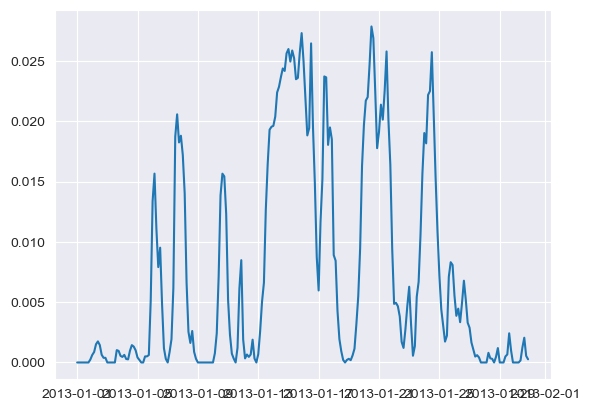

In [11]:
# generation of generator 'AL0 0 offwind-ac' for first month
plt.plot(n.generators_t.p['AL0 0 offwind-ac'][month1])

In [12]:
# names of the different generators
n.generators_t.p.columns

Index(['AL0 0 offwind-ac', 'AL0 0 onwind', 'AL0 0 solar', 'AT0 0 onwind',
       'AT0 0 ror', 'AT0 0 solar', 'AT0 1 onwind', 'AT0 1 ror', 'AT0 1 solar',
       'AT0 2 onwind',
       ...
       'RS0 1 solar rooftop', 'SE3 0 solar rooftop', 'SE3 1 solar rooftop',
       'SE3 2 solar rooftop', 'SE3 3 solar rooftop', 'SE3 5 solar rooftop',
       'SE3 6 solar rooftop', 'SE3 7 solar rooftop', 'SI0 0 solar rooftop',
       'SK0 0 solar rooftop'],
      dtype='object', name='Generator', length=1707)

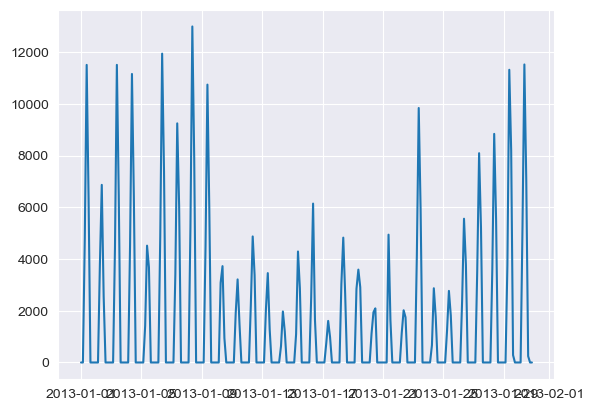

In [13]:
plt.plot(n.generators_t.p[month1]['AL0 0 solar'])

In [14]:
# market values: "onwind", "solar", "solar rooftop", "offwind-dc", "offwind-ac"
mv_onwind = market_values(n, "onwind")
mv_onwind

Generator
AL0 0    131.075254
AT0 0     83.457109
AT0 1     84.612302
AT0 2     90.012931
BA0 0    119.715551
            ...    
SE3 5     60.351733
SE3 6     53.277864
SE3 7     63.297661
SI0 0    125.246390
SK0 0     91.144751
Length: 181, dtype: float64

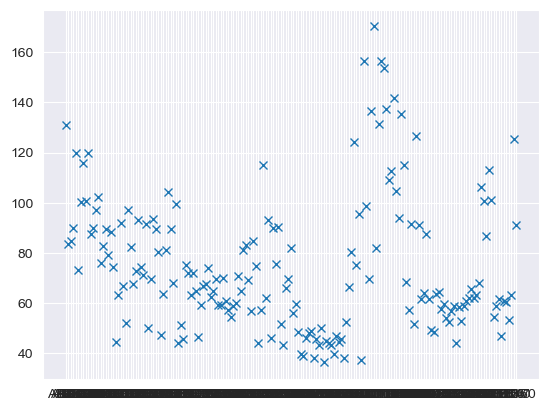

In [15]:
plt.plot(mv_onwind,'x')

In [16]:
# shadow prices (in €/MWh) for every nod/bus and time step
# (e.g. Locational Marginal Price (LMP) for electricity)
n.buses_t.marginal_price

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,208.089324,187.447538,132.306353,87210.617893,203.956540,207.193448,208.101095,56.974139,58.124200,98.687337,...,37.759799,125.280135,118.864605,118.047631,100.123259,-513.283465,-358.677321,113.318707,-414.293975,78.325642
2013-01-01 03:00:00,208.030183,187.447686,132.305622,132.315961,203.902052,205.714306,208.041610,57.018315,60.356861,231.005065,...,123.354232,131.588893,127.508619,119.289047,100.193499,-513.283465,-358.677360,113.334089,-412.864209,78.419905
2013-01-01 06:00:00,153.808216,187.447826,132.304178,132.314517,156.989409,169.934834,168.694456,185.978154,162.287216,187.391199,...,127.469042,131.586472,131.094079,119.372125,100.263177,-513.283465,-358.677378,113.349609,-412.188901,78.490917
2013-01-01 09:00:00,89.821566,182.553882,132.127980,132.138319,156.989293,167.097474,164.289516,45.035153,48.301899,125.271125,...,125.676186,125.283858,128.344296,119.430310,100.331808,-513.283465,-358.677391,113.365708,-411.875232,78.559337
2013-01-01 12:00:00,153.339481,182.554338,132.303825,132.314163,156.989346,167.635541,164.290191,45.045361,48.062406,125.255829,...,124.979069,125.281745,128.271108,119.428606,100.400904,-513.283465,-358.677399,113.395103,-411.642917,78.642735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,199.844657,187.446471,132.308110,132.318449,203.986154,201.531371,199.854464,56.431556,57.994492,79.089352,...,37.617372,125.278126,126.196737,118.054180,99.774169,-513.283465,-358.677308,112.957515,-407.839459,78.502628
2013-12-31 12:00:00,199.855407,187.446782,132.308083,132.318421,203.986169,202.085946,199.865679,56.451729,58.044303,77.418336,...,36.567638,125.275258,125.383352,118.052955,99.843746,-513.283465,-358.677296,112.949373,-407.825246,78.497642
2013-12-31 15:00:00,208.203744,187.447032,132.307921,132.318259,203.986319,206.444218,208.217403,58.830340,58.841772,125.150310,...,37.770381,125.276215,123.458995,118.054432,99.913423,-513.283465,-358.677267,112.944123,-407.815666,78.487410


In [17]:
carrier = "onwind"
# select all the generators for specific carrier e.g. onwind
gen = n.generators_t.p.loc[:, n.generators.carrier == carrier]
# create index from the generators and use as column names
gen.columns = gen.columns.map(n.generators.bus)
# get locational marginal prices for all locations and all time steps
lmp = n.buses_t.marginal_price.loc[:, gen.columns]

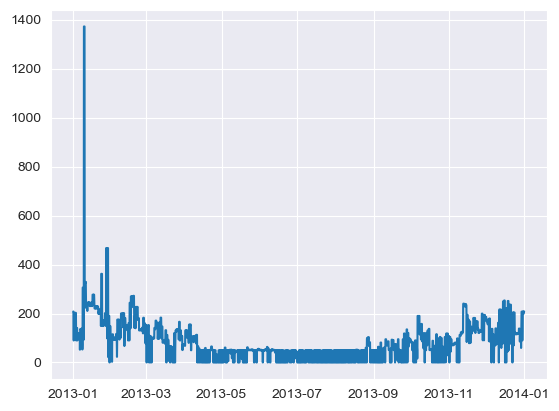

In [18]:
# plot of lmp of AL0 0
plt.plot(lmp["AL0 0"])

In [19]:
# calculate market values as sum product of generation times lmp divided by total generation
mv = (gen * lmp).sum() / gen.sum()
# set location of the buses/nodes as the index -> shape = (n_generators x 1) 1 col with mvs
mv.index = mv.index.map(n.buses.location)

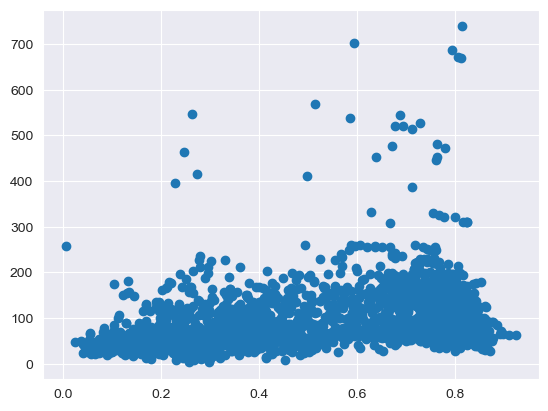

In [20]:
# plot: carrier market value plotted against carrier share
market_share = gen.sum(axis=1) / n.generators_t.p.sum(axis=1)
plt.scatter(market_share, lmp.mean(axis=1))

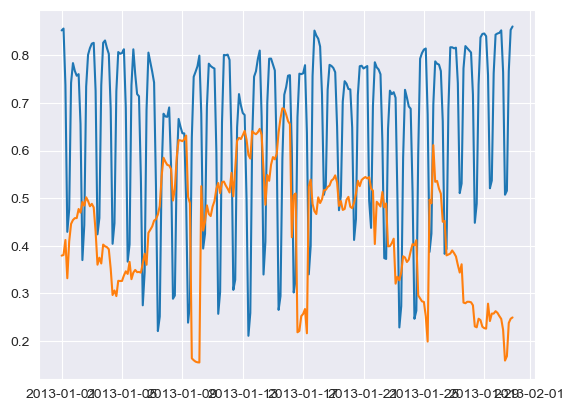

In [21]:
plt.plot(market_share[month1])
plt.plot((lmp.mean(axis=1)/lmp.max(axis=1))[month1])

In [22]:
lmp.mean(axis=1)

snapshot
2013-01-01 00:00:00    85.479561
2013-01-01 03:00:00    85.802057
2013-01-01 06:00:00    80.220032
2013-01-01 09:00:00    62.647400
2013-01-01 12:00:00    79.642487
                         ...    
2013-12-31 09:00:00    67.913761
2013-12-31 12:00:00    83.950352
2013-12-31 15:00:00    94.985838
2013-12-31 18:00:00    94.840804
2013-12-31 21:00:00    94.195651
Length: 2920, dtype: float64

In [23]:
market_share

snapshot
2013-01-01 00:00:00    0.852412
2013-01-01 03:00:00    0.856350
2013-01-01 06:00:00    0.737621
2013-01-01 09:00:00    0.429234
2013-01-01 12:00:00    0.476010
                         ...   
2013-12-31 09:00:00    0.454882
2013-12-31 12:00:00    0.475002
2013-12-31 15:00:00    0.760517
2013-12-31 18:00:00    0.817064
2013-12-31 21:00:00    0.820200
Length: 2920, dtype: float64

In [24]:
test = pd.concat([market_share, lmp.mean(axis=1)], axis=1)
test.columns = ["market_share", "lmp"]
test.set_index("market_share", inplace=True)
test.sort_index(ascending=True)

,lmp
market_share,
0.004559,257.072458
0.024893,48.411784
0.035941,50.121329
0.039467,42.834398
0.040391,42.570327
...,...
0.890092,64.655837
0.893312,70.894865
0.898062,65.795213


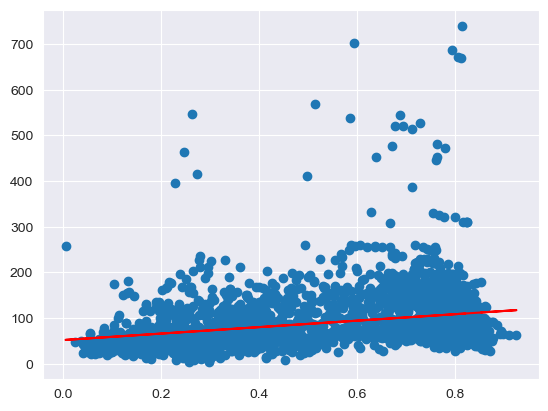

In [25]:
plt.scatter(test.index, test.lmp)
m, b = np.polyfit(test.index, test.lmp, 1)
plt.plot(test.index, m*test.index+b, color="red")

In [26]:
mv_onwind = market_values(n,"onwind")

In [27]:
# Link between two buses with controllable active power - can be used for a transport power flow model OR as a simplified version of point-to-point DC connection OR as a lossy energy converter. NB: for a lossless bi-directional HVDC or transport link, set p_min_pu = -1 and efficiency = 1. NB: It is assumed that the links neither produce nor consume reactive power.

n.links_t.p0

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-373.224322,-249.993237,0.0,0.0,0.0,0.0,599.976038,-499.963378,999.540578,-597.418961,...,0.0,0.0,0.0,0.0,0.0,0.032368,33597.122837,0.001197,0.017103,89091.812555
2013-01-01 03:00:00,-437.541123,-249.993058,0.0,0.0,0.0,0.0,516.626986,-499.965632,999.966753,-599.975228,...,0.0,0.0,0.0,0.0,0.0,0.032540,33597.122647,0.001188,0.017149,89091.812503
2013-01-01 06:00:00,515.030831,-249.993312,0.0,0.0,0.0,0.0,22.926537,-499.996982,999.971128,-599.927696,...,0.0,0.0,0.0,0.0,0.0,0.032681,33597.122490,0.001184,0.017191,89091.812457
2013-01-01 09:00:00,999.992935,-249.986233,0.0,0.0,0.0,0.0,-0.003338,499.961155,999.971371,-599.972055,...,0.0,0.0,0.0,0.0,0.0,0.032795,33597.122364,0.001184,0.017225,89091.812419
2013-01-01 12:00:00,-999.753630,-249.992932,0.0,0.0,0.0,0.0,-17.666072,336.640918,999.971740,-599.885795,...,0.0,0.0,0.0,0.0,0.0,0.032924,33597.122220,0.001187,0.017272,89091.812366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-234.716347,-249.992745,0.0,0.0,0.0,0.0,51.158434,-499.954895,560.748082,-599.886990,...,0.0,0.0,0.0,0.0,0.0,0.034309,33597.120681,0.001410,0.017514,89091.812098
2013-12-31 12:00:00,-999.993634,-249.992624,0.0,0.0,0.0,0.0,17.963294,-499.957181,347.496530,-599.886507,...,0.0,0.0,0.0,0.0,0.0,0.034310,33597.120680,0.001408,0.017511,89091.812101
2013-12-31 15:00:00,45.771531,-249.992412,0.0,0.0,0.0,0.0,8.645707,-499.940458,998.984391,-599.884190,...,0.0,0.0,0.0,0.0,0.0,0.034304,33597.120686,0.001404,0.017508,89091.812104


In [28]:
n.components

{'Network': {'list_name': 'networks',
  'description': 'Container for all components and functions which act upon the whole network.',
  'type': nan,
  'attrs':                                                          type     unit  \
  attribute                                                                
  name                                                   string      NaN   
  snapshots                                list or pandas.Index      NaN   
  snapshot_weightings                          pandas.DataFrame   hours    
  investment_periods                               pandas.Index    years   
  investment_period_weightings                 pandas.DataFrame      NaN   
  now                                                       any      NaN   
  srid                                                  integer      NaN   
  buses                                        pandas.DataFrame      NaN   
  buses_t                       dictionary of pandas.DataFrames      NaN   
  lin

In [29]:
# market value for the 181 onwind generators (k-mean clusters)
mv_onwind

Generator
AL0 0    131.075254
AT0 0     83.457109
AT0 1     84.612302
AT0 2     90.012931
BA0 0    119.715551
            ...    
SE3 5     60.351733
SE3 6     53.277864
SE3 7     63.297661
SI0 0    125.246390
SK0 0     91.144751
Length: 181, dtype: float64

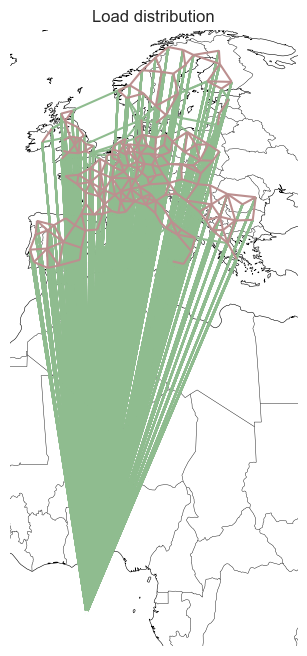

In [30]:
fig, ax = plt.subplots(
    1, 1, subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(8, 8)
)

load_distribution = (
    n.loads_t.p_set.loc[n.snapshots[0]].groupby(n.loads.bus).sum()
)
n.plot(bus_sizes=1e-5 * load_distribution, ax=ax, title="Load distribution");

AssertionError: Colors not defined for all elements in the second MultiIndex level of bus_sizes, please make sure that all the elements are included in bus_colors or in n.carriers.color

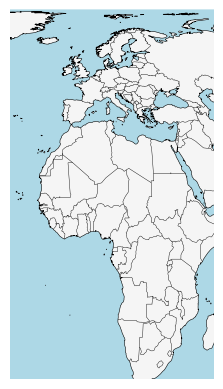

In [31]:
gen = n.generators.assign(g=n.generators_t.p.mean()).groupby(["bus", "carrier"]).g.sum()
flow = pd.Series(10, index=n.branches().index)
# Pandas series with MultiIndex
# links are not displayed for prettier output ('link_widths=0')
collection = n.plot(
    bus_sizes=gen / 5e3,
    bus_colors={"gas": "indianred", "wind": "midnightblue"},
    margin=0.5,
    flow=flow,
    line_widths=2.7,
    link_widths=0,
    projection=ccrs.EqualEarth(),
    color_geomap=True,
    line_colors=n.lines_t.p0.mean().abs(),
)

plt.colorbar(collection[2], fraction=0.04, pad=0.004, label="Flow in MW")
plt.show()

In [ ]:
p_by_carrier = n.generators_t.p.groupby(n.generators.carrier, axis=1).sum()
p_by_carrier.drop(
    (p_by_carrier.max()[p_by_carrier.max() < 1700.0]).index, axis=1, inplace=True
)
p_by_carrier.columns

In [ ]:
colors = {
    "oil": "k",
    "offwind-dc": "r",
    "onwind": "green",
    "ror": "blue",
    "solar": "yellow",
    "offwind-ac": "cyan",
    "solar rooftop": "brown",
    "gas": "orange",
    "urban central solar thermal": "pink"
}
# reorder
cols = [
    "oil",
    "gas",
    "ror",
    "offwind-ac",
    "offwind-dc",
    "onwind",
    "solar",
    "solar rooftop",
    "urban central solar thermal",
]
p_by_carrier = p_by_carrier[cols]

In [ ]:
p_by_carrier.max()

In [ ]:
(p_by_carrier / 1e3).max()

In [ ]:
(p_by_carrier[p_by_carrier.index > datetime.datetime(2013,1,31) & p_by_carrier.index < datetime.datetime(2013,3,1) ] / 1e3)

In [ ]:
index = (p_by_carrier.index > datetime.datetime(2013,3,31)) & (p_by_carrier.index < datetime.datetime(2013,5,1)) # huge peak for 16.02
c = [colors[col] for col in p_by_carrier.columns]

fig, ax = plt.subplots(figsize=(12, 6))
(p_by_carrier[index] / 1e3).plot(kind="area", ax=ax, linewidth=4, color=c, alpha=0.7)
ax.legend(ncol=4, loc="upper left")
ax.set_ylabel("GW")
ax.set_xlabel("")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))

p_storage = n.storage_units_t.p.sum(axis=1)
state_of_charge = n.storage_units_t.state_of_charge.sum(axis=1) / 1e3
p_storage.plot(label="Pumped hydro dispatch (MWh)", ax=ax, linewidth=3)
state_of_charge.plot(label="State of charge (GWh)", ax=ax, linewidth=3)

ax.legend()
ax.grid()
ax.set_ylabel("")
ax.set_xlabel("")
fig.tight_layout()

In [ ]:
snap = n.snapshots[4]
snap

In [ ]:
loading = n.lines_t.p0.loc[snap] / n.lines.s_nom
loading[loading.isnull()] = 0

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.EqualEarth()}, figsize=(9, 9))
n.plot(
    ax=ax,
    line_colors=abs(loading),
    line_cmap=plt.cm.jet,
    title="Line loading",
    bus_sizes=1e-3,
    bus_alpha=0.7,
)
fig.tight_layout();

In [ ]:
# 181 regions
y = n.buses[n.buses.x != 0].y
x = n.buses[n.buses.x != 0].x
names = n.buses[n.buses.x != 0].index

fig, ax = plt.subplots(figsize=(18, 8))
ax.scatter(x, y)

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]))


In [ ]:
# marginal prices
n.buses_t.marginal_price.loc[snap].describe()

In [ ]:
n.buses[n.buses.x != 0].index

In [ ]:
n.buses_t.marginal_price.loc[snap,n.buses[n.buses.x != 0].index]

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    n.buses[n.buses.x != 0].x,
    n.buses[n.buses.x != 0].y,
    gridsize=20,
    C=n.buses_t.marginal_price.loc[snap,n.buses[n.buses.x != 0].index],
    cmap=plt.cm.jet,
    zorder=3,
)
# n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index), bus_sizes=0)

cb = plt.colorbar(location="bottom")
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()

In [ ]:
fig, ax = plt.subplots(subplot_kw={"projection": ccrs.PlateCarree()}, figsize=(8, 8))

plt.hexbin(
    n.buses.x,
    n.buses.y,
    gridsize=20,
    C=n.buses_t.marginal_price.loc[snap],
    cmap=plt.cm.jet,
    zorder=3,
)
n.plot(ax=ax, line_widths=pd.Series(0.5, n.lines.index), bus_sizes=0)

cb = plt.colorbar(location="bottom")
cb.set_label("Locational Marginal Price (EUR/MWh)")
fig.tight_layout()

### Geopandas Intro

In [ ]:
geometry = gpd.points_from_xy(n.buses[n.buses.x != 0].x, n.buses[n.buses.x != 0].y)
gdf = gpd.GeoDataFrame(n.buses[n.buses.x != 0], geometry=geometry, crs=4326)
gdf.plot()
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax = plt.axes(projection=ccrs.Mollweide())
ax.stock_img()
fig = plt.figure(figsize=(8, 10))

ax = plt.axes(projection=ccrs.PlateCarree())

gdf.plot(
    ax=ax
)
ax.coastlines()
ax.add_feature(cartopy.feature.BORDERS, color='grey', linewidth=0.5)
ax.add_feature(cartopy.feature.OCEAN, color='azure')
ax.add_feature(cartopy.feature.LAND, color='cornsilk')
# ax.set_extent([5, 16, 47, 55])
fig = plt.figure(figsize=(7, 7))

crs = ccrs.AlbersEqualArea()

ax = plt.axes(projection=crs)

gdf.to_crs(crs.proj4_init).plot(
    ax=ax
)

ax.coastlines()